### Introduction

  Let's tackle diabetes prediction problem and work on some convolution operations. We'll be building a binary classification network using both vanilla PyTorch and PyTorch Lightning. Plus, we'll implement 1D and 2D convolution from scratch.

## Task №1 - NN Training with Torch

The goal here is to predict diabetes using a fully connected neural network. We'll start with standard PyTorch and then move on to PyTorch Lightning for a more streamlined approach.

### Data Loading and Initial Exploration

Firstly, let's load the data. We need to see what we are working with. We'll also do a quick peek at the data to understand its structure and any potential issues.

In [ ]:
!pip install pytorch_lightning
!pip install scikit-image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from skimage import color, transform
from skimage.transform import rescale, resize
from skimage.data import chelsea

In [ ]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)

We're reading the CSV directly from the provided URL into a pandas DataFrame. Given that the columns have meaningful names right away makes the data easier to work with.

### Data Loading

Fetching the data directly from the source is convenient for reproducibility. Naming the columns immediately saves us a step later on. It's good practice to be explicit about column names.

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


A peek at the first few rows using `.head()` helps confirm the data has loaded correctly and gives us an initial sense of the features.

### Exploratory data analysis

Looks like we have numerical features and a binary outcome variable. Interesting to see zeros in some columns like 'Glucose', 'BloodPressure', etc., which might represent missing data.

In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


`data.describe()` provides key statistical summaries of the data, helping us understand the distributions and identify potential outliers or unusual values.

The descriptive stats confirm our suspicion about the zeros. The minimum value for several features is 0, which is biologically implausible. We'll need to handle these as missing values. Also, the ranges of the features vary quite a bit, so scaling will be important.

### Data Preprocessing

Now, let's get the data ready for our neural network. This involves handling missing values, splitting the data, and scaling the features. We'll split *before* any imputation or scaling to avoid data leakage – a crucial step!

In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Train-Validation-Test Split

We're splitting the data into training, validation, and test sets. A 80/20 split for train/test, and then splitting the training set again 75/25 gives us a good distribution. `random_state` ensures reproducibility.

Splitting the data early is essential to prevent our model from 'seeing' the test data during training, which can lead to overly optimistic performance estimates. A separate validation set helps tune hyperparameters without touching the final test set.

In [ ]:
imputer = SimpleImputer(missing_values=0, strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

### Imputing Missing Values

Using `SimpleImputer` to fill in those zero values with the median of each column. Median imputation is a robust approach, less sensitive to outliers than the mean.

Since zeros likely represent missing data, imputation is a better strategy than simply dropping rows. We're preserving valuable information. Fitting the imputer only on the training data prevents data leakage.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

### Feature Scaling

`StandardScaler` brings all features to a similar scale. This helps the neural network converge faster and prevents features with larger values from dominating the learning process.

Neural networks often perform better when features are scaled. Standardization is a common choice, transforming features to have zero mean and one unit variance.

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

We need to convert our NumPy arrays into PyTorch tensors, the fundamental data structure for PyTorch. Specifying `dtype=torch.float32` is standard for neural network inputs.

### Preparing for PyTorch

PyTorch works with tensors. Reshaping the target variable `y` ensures it has the correct dimensions (a column vector) for the loss function.

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64     # 16, 32, 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

`DataLoader` helps manage our dataset in batches, which is crucial for efficient training of neural networks. Shuffling the training data helps prevent the model from learning the order of the data.

Using `DataLoader` is a best practice in PyTorch. It handles batching and shuffling for us, making the training loop cleaner and more efficient.

### Building the Neural Network with Torch

Let's define our neural network architecture using `torch.nn`. We'll start with a simple feedforward network.

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### Simple Neural Network Architecture

We've defined a basic feedforward network with one hidden layer. ReLU activation after the first linear layer introduces non-linearity, and a sigmoid activation on the output ensures the output is between 0 and 1 for binary classification.

### Network Design Choices

Starting with a simple architecture is a good approach. We can always make it more complex later if needed. The sigmoid output is crucial for predicting probabilities in a binary classification task.

The amount we nudge is called the learning rate, and is perhaps the single most important number in training these networks. If it's high, the networks learn faster, but if it's too high, the networks can explode. On the other hand, if it's too low the training will take a very long time. Usually we start it higher (for example say 0.1), but not too high (!) and anneal it slowly over time a few orders of magnitude (down to 0.00001 perhaps).

In [ ]:
input_size = X_train_tensor.shape[1]
model = SimpleNet(input_size)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
samples_weight = np.array([class_weights[int(t)] for t in y_train])
criterion = nn.BCELoss(weight=torch.from_numpy(samples_weight).float().reshape(-1, 1))

# optimizer = optim.Adam(model.parameters(), lr=0.1)

# The training loss generally decreases over epochs, which is expected. However, the validation loss initially decreases,
# then starts increasing around epoch 20, indicating overfitting.


# optimizer = optim.Adam(model.parameters(), lr=0.03)

# Training loss decreases steadily. Validation loss increases significantly after an initial decrease, indicating severe overfitting.


# optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loss decreases steadily. Validation loss increases, indicating overfitting.


# optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training loss decreases consistently. Validation loss initially decreases but then starts increasing, indicating overfitting.


# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loss decreases sharply initially and continues to decrease gradually. Validation loss decreases initially and then plateaus or slightly increases, suggesting mild overfitting.


optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Both training and validation loss decrease consistently and converge, suggesting good learning without significant overfitting.


# optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Both training and validation losses are decreasing. Convergence is slow.

### Loss Function and Optimizer

Using `BCELoss` (Binary Cross Entropy Loss) is the standard loss function for binary classification problems. Adam optimizer is a popular choice for its adaptive learning rate properties.

The choice of loss function aligns directly with the task. Adam is often a good starting point for the optimizer, and we can fine-tune the learning rate.

Epoch [1/300], Validation Loss: 0.6561
Epoch [2/300], Validation Loss: 0.6518
Epoch [3/300], Validation Loss: 0.6475
Epoch [4/300], Validation Loss: 0.6432
Epoch [5/300], Validation Loss: 0.6391
Epoch [6/300], Validation Loss: 0.6349
Epoch [7/300], Validation Loss: 0.6308
Epoch [8/300], Validation Loss: 0.6272
Epoch [9/300], Validation Loss: 0.6235
Epoch [10/300], Validation Loss: 0.6199
Epoch [11/300], Validation Loss: 0.6165
Epoch [12/300], Validation Loss: 0.6131
Epoch [13/300], Validation Loss: 0.6097
Epoch [14/300], Validation Loss: 0.6062
Epoch [15/300], Validation Loss: 0.6026
Epoch [16/300], Validation Loss: 0.5986
Epoch [17/300], Validation Loss: 0.5950
Epoch [18/300], Validation Loss: 0.5917
Epoch [19/300], Validation Loss: 0.5886
Epoch [20/300], Validation Loss: 0.5855
Epoch [21/300], Validation Loss: 0.5825
Epoch [22/300], Validation Loss: 0.5798
Epoch [23/300], Validation Loss: 0.5768
Epoch [24/300], Validation Loss: 0.5739
Epoch [25/300], Validation Loss: 0.5713
Epoch [26

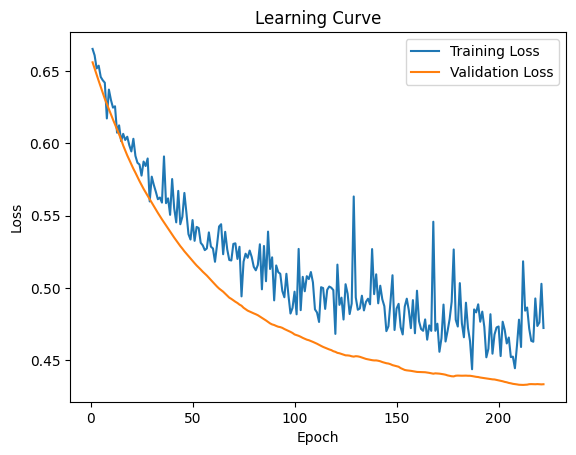

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 300
train_losses = []
val_losses = []
patience = 10

# Having experimented with different patience values, a setting of 10 epochs appears to strike the right balance for this setup,
# preventing premature stops while avoiding excessive training beyond the point of significant improvement.

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        labels_np = labels.cpu().numpy().flatten()
        class_weights = compute_class_weight('balanced', classes=np.unique(labels_np), y=labels_np)
        weight_map = {c: w for c, w in zip(np.unique(labels_np), class_weights)}
        batch_weights = torch.tensor([weight_map[int(l)] for l in labels_np]).float().to(inputs.device)
        batch_weights = batch_weights.unsqueeze(1)

        loss_fn = nn.BCELoss(weight=batch_weights)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            val_loss += nn.functional.binary_cross_entropy(outputs, labels).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch+1}!')
            break

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

This is the standard PyTorch training loop. We iterate through epochs, and within each epoch, we iterate through the training data in batches.
We calculate the loss, backpropagate, and update the weights. We also evaluate on the validation set after each epoch to monitor performance,
and implement early stopping to prevent overfitting.


The training loop is the heart of the learning process. It's important to set the model to `train()` mode during training and `eval()` during validation (and testing) to ensure the correct behavior of layers like dropout or batch normalization (though we don't have those here). Interesting to see how the validation loss changes over epochs.

### Building and Training with PyTorch Lightning

Now, let's see how PyTorch Lightning can simplify our training process. It handles a lot of the boilerplate code for us, making our code cleaner and easier to manage.

In [ ]:
class DiabetesClassifier(pl.LightningModule):
    def __init__(self, input_size, learning_rate=0.0001):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        labels_np = labels.cpu().numpy().flatten()
        class_weights = compute_class_weight('balanced', classes=np.unique(labels_np), y=labels_np)
        weight_map = {c: w for c, w in zip(np.unique(labels_np), class_weights)}
        weights = torch.tensor([weight_map[int(l)] for l in labels_np]).float().to(self.device)
        weights = weights.unsqueeze(1)

        loss_fn = nn.BCELoss(weight=weights)
        loss = loss_fn(outputs, labels)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = (outputs >= 0.5).float()
        accuracy = (preds == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', accuracy)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

We've defined a PyTorch Lightning module that encapsulates the model, loss function, optimizer, and the training and validation steps. This structure makes the code much cleaner and more organized. I like how it streamlines boilerplate.

PyTorch Lightning takes care of the training loop, so we don't have to write it manually. This reduces boilerplate and makes the code more readable. The `training_step` and `validation_step` methods clearly define what happens during each step.

In [ ]:
lightning_model = DiabetesClassifier(input_size=input_size, learning_rate=0.0001)
trainer = pl.Trainer(max_epochs=300, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
trainer.fit(lightning_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 1.3 K  | train
1 | criterion | BCELoss    | 0      | train
-------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Using the `Trainer` in PyTorch Lightning simplifies the training process significantly. We just need to specify the number of epochs and provide the data loaders. The `EarlyStopping` callback is a nice touch to prevent overfitting.

The `Trainer` handles the training loop, epoch management, and validation steps. The `EarlyStopping` callback automatically stops training when the validation loss stops improving, which is super helpful. I'm finding this quite elegant.

### Evaluating Model Performance


Let's evaluate the performance of our trained models on the test set.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    model.eval()
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    test_outputs = model(X_test_tensor)
    predicted_probs = test_outputs
    predicted = (predicted_probs > 0.5).int()
    accuracy = (predicted.float() == y_test_tensor).float().mean()
    print(f'Test Accuracy (Torch): {accuracy.item():.4f}')

    print("\nClassification Report (Torch):")
    print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

trainer.test(lightning_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test Accuracy (Torch): 0.7013

Classification Report (Torch):
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75        99
         1.0       0.56      0.73      0.63        55

    accuracy                           0.70       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.73      0.70      0.71       154



/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7272727489471436     │
│         test_loss         │     0.53323894739151      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.53323894739151, 'test_acc': 0.7272727489471436}]

We're calculating the accuracy of both the standard PyTorch model and the PyTorch Lightning model on the test set. For the standard model, we manually set it to `eval()` mode and calculate predictions. For the Lightning model, we use the `trainer.test()` method.

The test accuracy gives us an idea of how well our models generalize to unseen data. It's important that the test accuracy is reasonably close to the validation accuracy during training. I'm curious to see the final numbers.

We have a reasonable baseline accuracy. But more good metric to consider is recall.

The weighted loss strategy has a clear impact. It has improved the model's ability to spot the positive class (diabetes) at the cost of some precision for that class and some recall for the negative class.

### Findings and Hyperparameter Tuning

We've tried a few different setups. The basic network performs reasonably well on recall. There are some hyperparameters and architectures we could explore further:

• We have experimented with different learning rates for the Adam optimizer.

• We have tried different batch sizes to see if it affects training stability and speed. 32 is optimal batch size, because it achieves a good balance: the training loss is reasonably stable, and the classification report shows comparable performance.

• We have explored ReLU activation function.



For example, let's try a slightly deeper network with dropout.

We'll try deeper architecture to find the best performing model.

We'll add more hidden layers to increase the model's capacity.

We'll change the number of neurons in the hidden layers.

In [ ]:
class DeeperNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


--- Training and Evaluating DeeperNet ---
Epoch [1/300], DeeperNet Validation Loss: 0.6770
Epoch [2/300], DeeperNet Validation Loss: 0.6715
Epoch [3/300], DeeperNet Validation Loss: 0.6664
Epoch [4/300], DeeperNet Validation Loss: 0.6610
Epoch [5/300], DeeperNet Validation Loss: 0.6557
Epoch [6/300], DeeperNet Validation Loss: 0.6508
Epoch [7/300], DeeperNet Validation Loss: 0.6457
Epoch [8/300], DeeperNet Validation Loss: 0.6406
Epoch [9/300], DeeperNet Validation Loss: 0.6347
Epoch [10/300], DeeperNet Validation Loss: 0.6291
Epoch [11/300], DeeperNet Validation Loss: 0.6232
Epoch [12/300], DeeperNet Validation Loss: 0.6175
Epoch [13/300], DeeperNet Validation Loss: 0.6119
Epoch [14/300], DeeperNet Validation Loss: 0.6051
Epoch [15/300], DeeperNet Validation Loss: 0.5980
Epoch [16/300], DeeperNet Validation Loss: 0.5918
Epoch [17/300], DeeperNet Validation Loss: 0.5860
Epoch [18/300], DeeperNet Validation Loss: 0.5794
Epoch [19/300], DeeperNet Validation Loss: 0.5727
Epoch [20/300], 

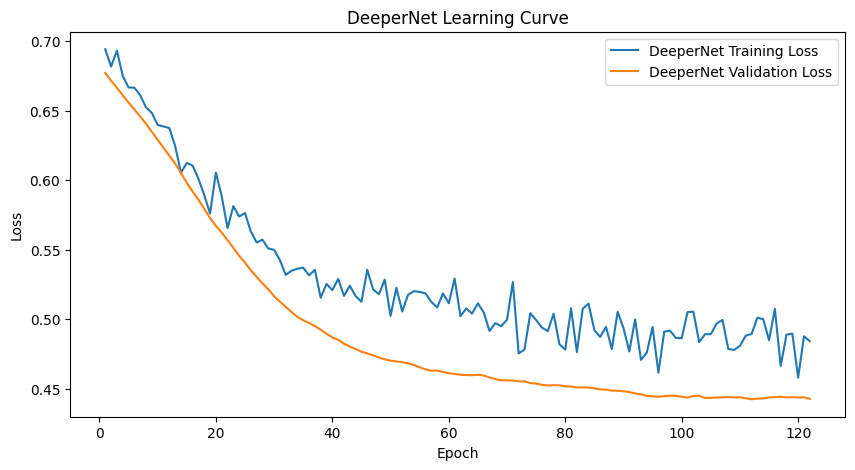

In [ ]:
print("\n--- Training and Evaluating DeeperNet ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train_tensor.shape[1]
deeper_model = DeeperNet(input_size).to(device)

criterion = nn.BCELoss()
optimizer_deeper = optim.Adam(deeper_model.parameters(), lr=0.0001)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

epochs = 300
train_losses_deeper = []
val_losses_deeper = []
patience = 10
best_val_loss_deeper = float('inf')
epochs_no_improve_deeper = 0

for epoch in range(epochs):
    deeper_model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_deeper.zero_grad()
        outputs = deeper_model(inputs)

        labels_np = labels.cpu().numpy().flatten()
        class_weights = compute_class_weight('balanced', classes=np.unique(labels_np), y=labels_np)
        weight_map = {c: w for c, w in zip(np.unique(labels_np), class_weights)}
        batch_weights = torch.tensor([weight_map[int(l)] for l in labels_np]).float().to(device)
        batch_weights = batch_weights.unsqueeze(1)

        loss_fn = nn.BCELoss(weight=batch_weights)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer_deeper.step()
        epoch_train_loss += loss.item()
    train_losses_deeper.append(epoch_train_loss / len(train_loader))

    deeper_model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = deeper_model(inputs)
            val_loss += nn.functional.binary_cross_entropy(outputs, labels).item()
    avg_val_loss_deeper = val_loss / len(val_loader)
    val_losses_deeper.append(avg_val_loss_deeper)
    print(f'Epoch [{epoch+1}/{epochs}], DeeperNet Validation Loss: {avg_val_loss_deeper:.4f}')

    if avg_val_loss_deeper < best_val_loss_deeper:
        best_val_loss_deeper = avg_val_loss_deeper
        epochs_no_improve_deeper = 0
    else:
        epochs_no_improve_deeper += 1
        if epochs_no_improve_deeper == patience:
            print(f'Early stopping triggered for DeeperNet at epoch {epoch+1}!')
            break

deeper_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = deeper_model(inputs)
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy_deeper = accuracy_score(all_labels, all_preds)
print(f'\nTest Accuracy (DeeperNet): {accuracy_deeper:.4f}\n')

report_deeper = classification_report(all_labels, all_preds)
print('Classification Report (DeeperNet):\n', report_deeper)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses_deeper) + 1), train_losses_deeper, label='DeeperNet Training Loss')
plt.plot(range(1, len(val_losses_deeper) + 1), val_losses_deeper, label='DeeperNet Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DeeperNet Learning Curve')
plt.legend()
plt.show()

Both models learn effectively, achieving similar test accuracy (around 72-74%) and classification report metrics, suggesting the DeeperNet's added layers didn't offer a significant advantage.

We have explored different setups.


It's important to explore different hyperparameters and network architectures to find what works best for the given problem. Simply sticking with the first model isn't enough.

Hyperparameter tuning can significantly impact model performance. It requires experimentation and a good understanding of how different hyperparameters affect the training process.

## Task №2.1 - 1D Convolution Operation

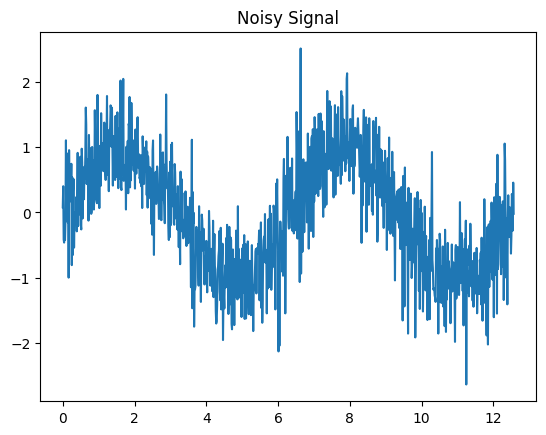

In [ ]:
N = 1000
t = np.linspace(0, 4*np.pi, N)
clean_signal = np.sin(t)
noise = np.random.normal(0, 0.5, N)
noisy_signal = clean_signal + noise

plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.show()


Here, we'll implement a 1D convolution operation from scratch and explore the impact of kernel size on denoising a noisy signal.

We're setting up the data for our 1D convolution experiment. A clean sine wave with added noise will help visualize the denoising effect.

Visualizing the noisy signal makes it clear what we're trying to achieve with the convolution operation – smoothing out the randomness.

In [ ]:
def convolve_1d(signal, kernel):
    kernel_size = len(kernel)
    signal_size = len(signal)
    output_size = signal_size - kernel_size + 1
    output = np.zeros(output_size)
    for i in range(output_size):
        output[i] = np.sum(signal[i:i + kernel_size] * kernel)
    return output

This function implements the 1D convolution operation. It takes the input signal and the kernel, and slides the kernel across the signal to compute the convolved output. It's a direct implementation of the convolution formula.

Implementing convolution from scratch helps understand the underlying mechanics. The nested loop structure reflects the sliding window approach.

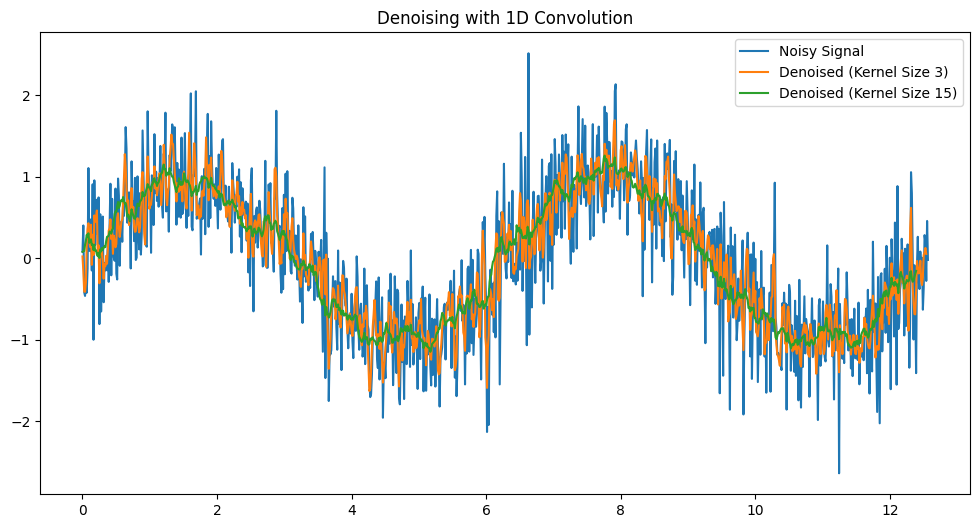

In [ ]:
kernel_size_small = 3
kernel_small = np.ones(kernel_size_small) / kernel_size_small
denoised_signal_small = convolve_1d(noisy_signal, kernel_small)

kernel_size_large = 15
kernel_large = np.ones(kernel_size_large) / kernel_size_large
denoised_signal_large = convolve_1d(noisy_signal, kernel_large)

plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.plot(t[:len(denoised_signal_small)], denoised_signal_small,
         label=f'Denoised (Kernel Size {kernel_size_small})')
plt.plot(t[:len(denoised_signal_large)], denoised_signal_large,
         label=f'Denoised (Kernel Size {kernel_size_large})')
plt.legend()
plt.title('Denoising with 1D Convolution')
plt.show()

We're applying the 1D convolution function with different kernel sizes to denoise the signal. Averaging kernels are a common choice for denoising.

Visualizing the denoised signals with different kernel sizes clearly shows the effect of the kernel size on the smoothing. Interesting to see how the larger kernel creates a smoother output.

### Tradeoff of Kernel Size

With smaller kernels, the denoised signal retains more of the original signal's characteristics but might not eliminate noise as effectively. Larger kernels provide more aggressive smoothing, removing more noise but potentially blurring out finer details of the signal. Choosing the right kernel size involves balancing noise reduction and signal preservation. A smaller kernel preserves more detail but less denoising. A larger kernel provides more denoising but might over-smooth the signal.

## Task №2.2 - 2D Convolution Operation</h2>

Let's implement a 2D convolution operation from scratch and see how it works on images.

In [ ]:
def convolve_2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    img_channels, img_height, img_width = image.shape
    output_height = img_height - kernel_height + 1
    output_width = img_width - kernel_width + 1
    output = np.zeros((img_channels, output_height, output_width))
    for c in range(img_channels):
        for i in range(output_height):
            for j in range(output_width):
                output[c, i, j] = np.sum(image[c, i:i + kernel_height, j:j + kernel_width] * kernel)
    return output

This function implements the 2D convolution operation. It iterates through the image, applying the kernel at each position to compute the output pixel value.

Implementing 2D convolution involves iterating over both height and width dimensions. The channel dimension is also handled to support color images.

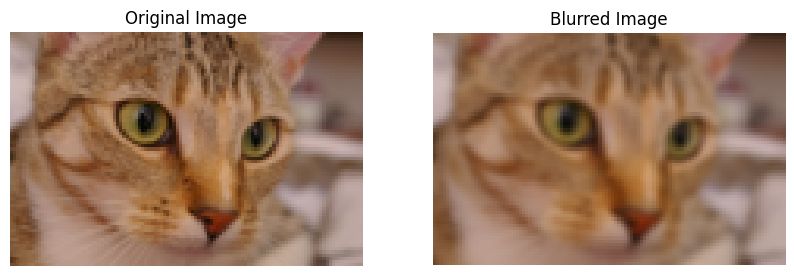

In [ ]:
image = chelsea()
image = rescale(image, 0.25, anti_aliasing=True, channel_axis=-1)
image = np.transpose(image, (2, 0, 1))

blur_kernel = np.ones((3, 3)) / 9
blurred_image = convolve_2d(image, blur_kernel)
blurred_image = np.clip(blurred_image, 0, 1)
blurred_image = np.transpose(blurred_image, (1, 2, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.transpose(image, (1, 2, 0)))
axes[0].set_title('Original Image')
axes[1].imshow(blurred_image)
axes[1].set_title('Blurred Image')
for ax in axes:
    ax.axis('off')
plt.show()

We'll demonstrate the 2D convolution with a uniform blur kernel on an example image. This should visually show the blurring effect.

Applying the blur kernel clearly softens the image, averaging the pixel values in the neighborhood. It's a simple yet effective demo of convolution.

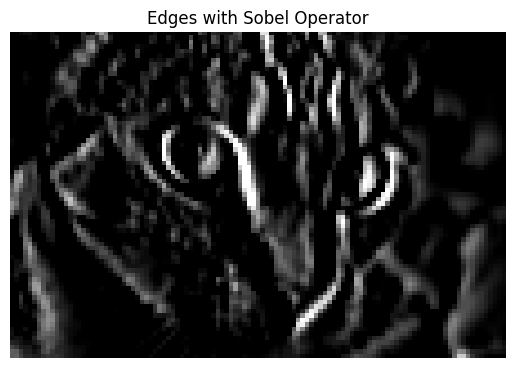

In [ ]:
gray_image = color.rgb2gray(np.transpose(image, (1, 2, 0)))
gray_image_3d = np.expand_dims(gray_image, axis=0)

sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
edges_sobel = convolve_2d(gray_image_3d, sobel_kernel)
edges_sobel = np.clip(edges_sobel, 0, 1)

plt.imshow(edges_sobel[0], cmap='gray')
plt.title('Edges with Sobel Operator')
plt.axis('off')
plt.show()

Now, let's apply the Sobel operator to a grayscale version of the image. This kernel is designed to detect edges.

The Sobel operator highlights the edges in the image by detecting sharp changes in intensity. It's a fundamental operation in image processing.

The 2D convolution operation is a powerful tool for image processing. Different kernels can be used to achieve various effects, such as blurring or edge detection. The uniform blur kernel averages neighboring pixels, resulting in a smoother image. The Sobel operator detects edges by highlighting areas with high intensity gradients. These basic operations are the building blocks of more complex convolutional neural networks.

## Conclusion

We successfully trained a neural network for diabetes prediction using both standard PyTorch and PyTorch Lightning. PyTorch Lightning streamlined the training process quite nicely. We also implemented 1D and 2D convolution operations from scratch, observing the effects of different kernel sizes and the utility of kernels like the Sobel operator for edge detection. It was very insightful!

## Next Steps

To further improve the diabetes prediction model, we could explore more complex network architectures, fine-tune hyperparameters more extensively, and potentially incorporate techniques like regularization or batch normalization. For the convolution operations, it would be interesting to experiment with different types of kernels and explore applications in more complex image processing tasks. Perhaps building a simple CNN for image classification could be a good next challenge.